# OC - Parcours Ingénieur IA - Projet 7 - BERKAN Asli Ceren

Le projet 7 réalisé dans le cadre du parcours ingénieur IA a pour but d'anticiper les bad buzz sur les réseaux sociaux de la compagnie aérienne "Air Paradis". Elle souhaite un prototype d'un produit IA permettant de prédire le sentiment associé à un tweet. 

Air Paradis ne possédant pas assez de données, un jeu de données Open Source est utilisé pour réaliser le projet. Il s'agit du jeu de données sentiment140. Il contient 1 600 000 tweets extraits à l'aide de l'API Twitter. Les tweets ont été annotés (0 = négatif, 4 = positif) et ils peuvent être utilisés pour détecter un sentiment. 

Pour ce faire, dans un premier temps, il faut pré-traiter les données textuelles. Par la suite, on utilisera les outils Microsoft Azure pour tester différentes approches :
- API sur étagère : utilisation de l'API du service cognitif proposé par Microsoft Azure pour l'analyse de sentiment, à tester sur quelques milliers d'exemples
- Modèle sur-mesure simple : utilisation du service Azure Machine Learning Studio (classic), interface graphique pour développer rapidement un modèle classique
- Modèle sur-mesure avancé : utilisation du service Azure Machine Learning pour développer un modèle basé sur les réseaux de neurones profonds, en utilisant deux word embeddings différents
    * Un modèle Keras de base avec embedding
    * Un modèle Keras avec embedding et couche LSTM
    * Un modèle BERT

## Prétraitement du texte <a class="anchor" id="section_1_1"></a>

In [1]:
import pandas as pd

# Affichage du jeu de données
dataset_columns = ['target', 'id', 'date', 'flag', 'user', 'text']
dataset_enconding = 'ISO-8859-1'
tweets = pd.read_csv('Data/training.1600000.processed.noemoticon.csv',
                     encoding=dataset_enconding, names=dataset_columns)

def affiche_df(data):
    """Cette fonction affiche plusieurs caractéristique
    d'une dataframe fournie en entrée :
    - La taille de la dataframe,
    - Les noms des colonnes,
    - Les types de données,
    - Le nombre de données manquantes par colonne,
    - Affichage des premières lignes.
    """
    dfTemp = pd.DataFrame(columns=['Nom des colonnes',
                                   'Type de données',
                                   'Nombre de données manquantes',
                                   'Le nombre de valeur unique'])

    taille_data = data.shape
    print('Le jeu de données contient '
          + str(taille_data[0])
          + ' lignes et '
          + str(taille_data[1])
          + ' colonnes. \n')
    
    dfTemp['Nom des colonnes'] = data.columns.tolist()
    dfTemp['Type de données'] = data.dtypes.tolist()
    dfTemp['Nombre de données manquantes'] = data.isnull(). sum().tolist()
    dfTemp['Le nombre de valeur unique'] = data.nunique().tolist()
    display(dfTemp)

    print('Affichage des premières lignes :')
    display(data.head(3))

affiche_df(tweets)

Le jeu de données contient 1600000 lignes et 6 colonnes. 



,Nom des colonnes,Type de données,Nombre de données manquantes,Le nombre de valeur unique
0,target,int64,0,2
1,id,int64,0,1598315
2,date,object,0,774363
3,flag,object,0,1
4,user,object,0,659775
5,text,object,0,1581466


Affichage des premières lignes :


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [2]:
# Target correspondance
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

tweets['target_string'] = tweets.target.apply(lambda x: decode_sentiment(x))
display(tweets.head(3))

,target,id,date,flag,user,text,target_string
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

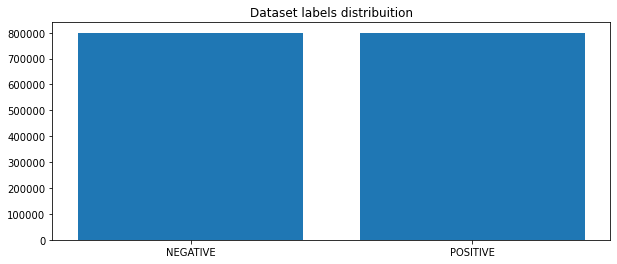

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# Affichage
target_cnt = Counter(tweets.target_string)

plt.figure(figsize=(10,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [4]:
# Échantillonage du jeu de données
n_sample = 11200 # pour avoir un jeu de test de 1600 et un jeu de val de 1600
tweets_sample = tweets.groupby('target_string').head(n_sample/2)
display(tweets_sample.head(3))
display(tweets_sample['target_string'].value_counts())

,target,id,date,flag,user,text,target_string
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE


NEGATIVE    5600
POSITIVE    5600
Name: target_string, dtype: int64

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Prétraitement
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+|[-+]?\d*\.\d+|\d+"

def preprocess(text, stem, lemmatize):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            elif lemmatize:
                tokens.append(lemmatizer.lemmatize(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
import time
import re

# Appliquer le prétraitement

tweets_sample['text_stem'] = tweets_sample.text.apply(lambda x: preprocess(x, stem=True, lemmatize=False))
tweets_sample['text_lemmatize'] = tweets_sample.text.apply(lambda x: preprocess(x, stem=False, lemmatize=True))

<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 2.5 s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
tweets_sample.head()

,target,id,date,flag,user,text,target_string,text_stem,text_lemmatize
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE,awww bummer shoulda got david carr third day,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE,upset updat facebook text might cri result sch...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE,dive mani time ball manag save rest go bound,dived many time ball managed save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NEGATIVE,whole bodi feel itchi like fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",NEGATIVE,behav mad see,behaving mad see


In [20]:
from sklearn.model_selection import train_test_split

# Train Test/Val Split
df_train, df_testVal = train_test_split(tweets_sample, test_size=3200, shuffle=True)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_testVal))

TRAIN size: 8000
TEST size: 3200


In [21]:
display(df_train['target_string'].value_counts())
display(df_testVal['target_string'].value_counts())

POSITIVE    4017
NEGATIVE    3983
Name: target_string, dtype: int64

NEGATIVE    1617
POSITIVE    1583
Name: target_string, dtype: int64

In [22]:
# Test Validation Split
df_test, df_val = train_test_split(df_testVal, test_size=0.5, shuffle=True)
print("TRAIN size:", len(df_test))
print("TEST size:", len(df_val))

TRAIN size: 1600
TEST size: 1600


In [23]:
display(df_test['target_string'].value_counts())
display(df_val['target_string'].value_counts())

POSITIVE    814
NEGATIVE    786
Name: target_string, dtype: int64

NEGATIVE    831
POSITIVE    769
Name: target_string, dtype: int64

In [24]:
# Save df_train and df_test
df_train.to_csv('df_train.csv', sep=',', encoding='utf-8')
df_test.to_csv('df_test.csv', sep=',', encoding='utf-8')
df_val.to_csv('df_val.csv', sep=',', encoding='utf-8')